<div style="text-align:center; margin-bottom:30px;">
  <h1 style="color:#1f77b4; font-size:38px; margin:0;">IMA 206 - Lab</h1>
  <h3 style="color:#ff7f0e; font-weight:normal; margin-top:8px;">
    Exercise 1: Convolution GAN for MNIST digits
  </h3>
</div>

<h3 style="color:#6EB5FF;">Import</h3>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is mps


<h3 style="color:#6EB5FF;">Download MNIST dataset</h3>

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [4]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.17MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 362kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.92MB/s]


Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


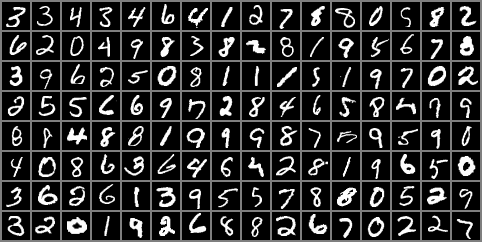

In [5]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

<h3 style="color:#6EB5FF;">Generator and Discriminator Models</h3>

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

In [6]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


<h3 style="color:#6EB5FF;">Display Samples of the Generator</h3>

In [7]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

<h3 style="color:#6EB5FF;">Weight initialization</h3>

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

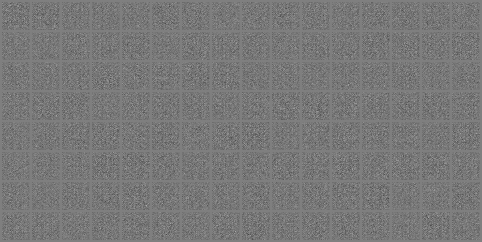

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

<h1 style="color:#007F5C;">Part 1: DCGAN Training with WGAN-GP loss</h1>

<br/><br/>
**QUESTION:** Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

You may get inspiration from the function $\texttt{lipconstant}$ given below.

In [ ]:

def gradient_penalty(D, x, y):
    # batch size
    b = x.size(0)
    # tirage alpha ∈ [0,1] pour interpolation
    alpha = torch.rand(b, 1, 1, 1, device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_() # on veut Delta_X

    # passage dans D
    Di = D(interp).view(-1)

    # calcul du gradient de D
    grad_outputs = torch.ones_like(Di, device=device)
    gradients = torch.autograd.grad(outputs=Di,inputs=interp,grad_outputs=grad_outputs,
                                    create_graph=True,retain_graph=True)[0]

    # norme L2 par image, +eps pour stabilité num.
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=[1, 2, 3]) + 1e-12)

    # pénalité
    return ((gradients_norm - 1) ** 2).mean()



def lipconstant(D,x,y):
    # Calculate interpolation between points in batches x and y (of same size b)
    b = x.shape[0]
    if y.shape[0]!=b:
        print('wrong size')
    alpha = torch.rand((b,1,1,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

tensor(0.0537, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.8852, device='mps:0', grad_fn=<MeanBackward0>)


<br/><br/>

**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

[1/5][0/468][4.2211 s]	Loss_D: -0.2949	Loss_G: 0.4877	Lip(D): 0.0420


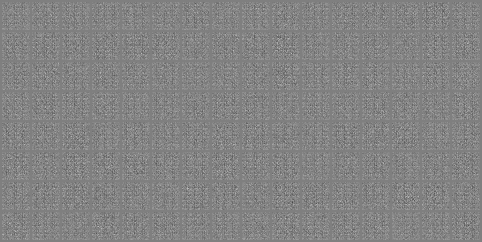

[1/5][100/468][15.2721 s]	Loss_D: -9.6420	Loss_G: 1.1609	Lip(D): 0.0665


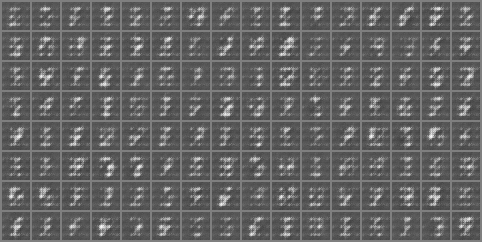

[1/5][200/468][26.4379 s]	Loss_D: -47.8625	Loss_G: 21.7728	Lip(D): 0.1302


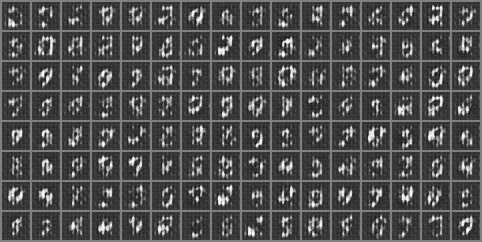

[1/5][300/468][37.5259 s]	Loss_D: -63.9112	Loss_G: 33.3986	Lip(D): 0.1605


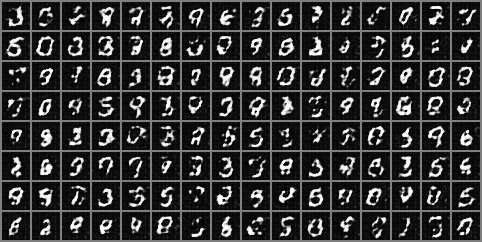

[1/5][400/468][48.6558 s]	Loss_D: -46.7673	Loss_G: 50.7972	Lip(D): 0.1445


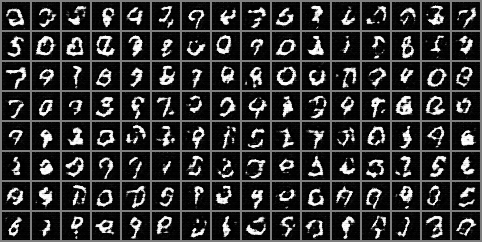

[2/5][0/468][57.8485 s]	Loss_D: -44.1709	Loss_G: 74.0968	Lip(D): 0.1167


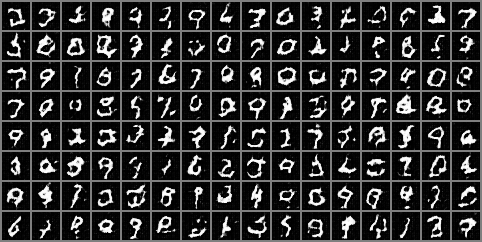

[2/5][100/468][69.0279 s]	Loss_D: -51.0671	Loss_G: 55.4971	Lip(D): 0.1860


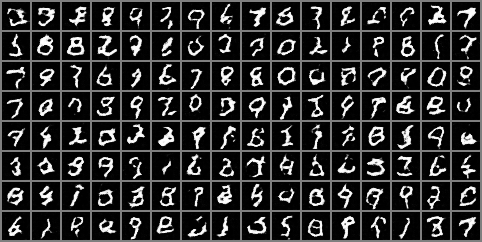

[2/5][200/468][80.2029 s]	Loss_D: -23.0024	Loss_G: 51.2104	Lip(D): 0.1931


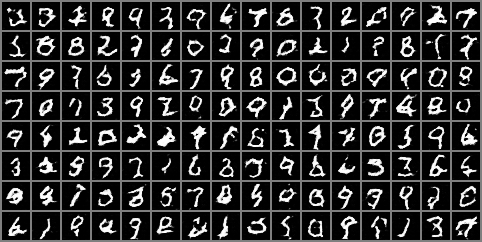

[2/5][300/468][91.3864 s]	Loss_D: -43.4338	Loss_G: 72.4048	Lip(D): 0.1346


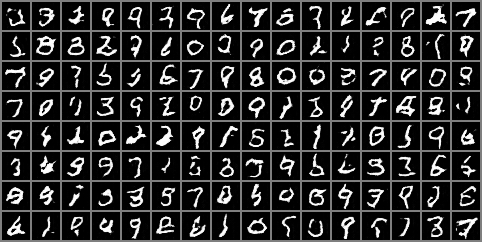

[2/5][400/468][102.4654 s]	Loss_D: -31.8200	Loss_G: 101.5247	Lip(D): 0.1895


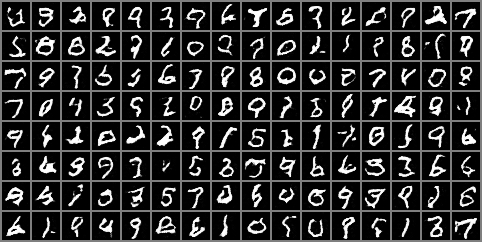

[3/5][0/468][111.3592 s]	Loss_D: -28.8520	Loss_G: 42.5914	Lip(D): 0.1538


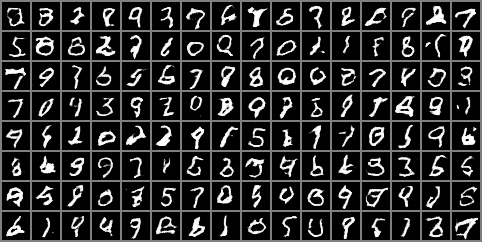

[3/5][100/468][122.4455 s]	Loss_D: -8.0240	Loss_G: 46.1964	Lip(D): 0.1902


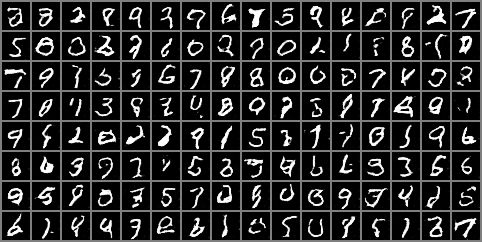

[3/5][200/468][133.5776 s]	Loss_D: -28.1011	Loss_G: 90.7389	Lip(D): 0.1389


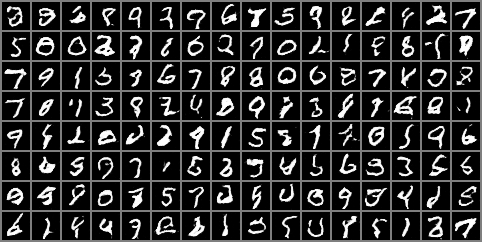

[3/5][300/468][144.8002 s]	Loss_D: -50.9253	Loss_G: 102.0713	Lip(D): 0.2388


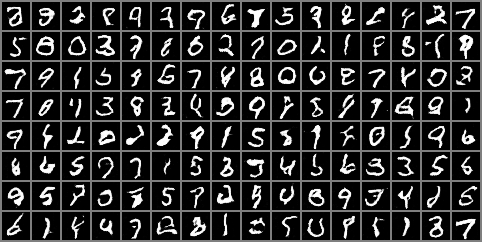

[3/5][400/468][155.9757 s]	Loss_D: -19.5899	Loss_G: 72.3213	Lip(D): 0.1824


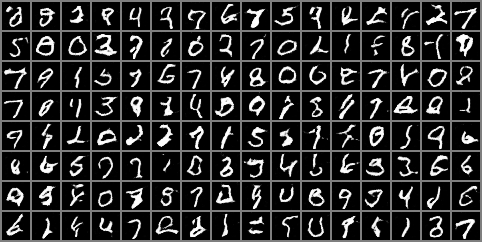

[4/5][0/468][164.9332 s]	Loss_D: -27.8041	Loss_G: 88.6787	Lip(D): 0.2580


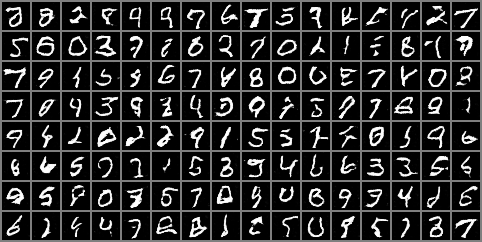

[4/5][100/468][176.0018 s]	Loss_D: -20.5540	Loss_G: 76.9913	Lip(D): 0.1721


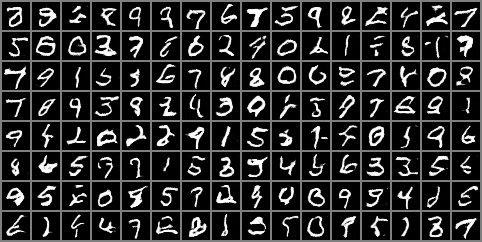

[4/5][200/468][187.1811 s]	Loss_D: -16.5255	Loss_G: 59.6697	Lip(D): 0.1790


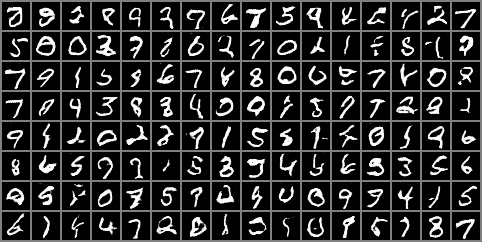

[4/5][300/468][198.3204 s]	Loss_D: -18.8789	Loss_G: 94.4288	Lip(D): 0.1787


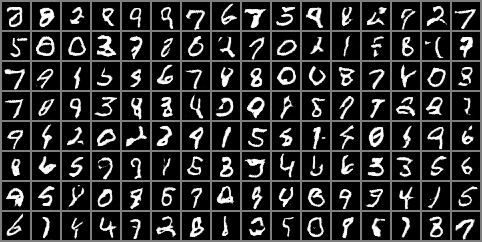

[4/5][400/468][209.4490 s]	Loss_D: 9.9865	Loss_G: 136.0798	Lip(D): 0.1565


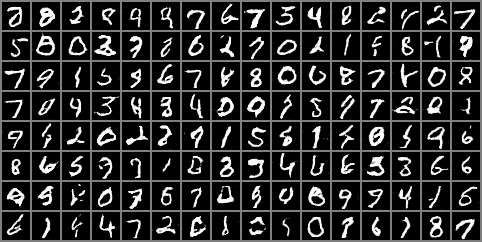

[5/5][0/468][218.5671 s]	Loss_D: -26.1783	Loss_G: 98.0026	Lip(D): 0.1863


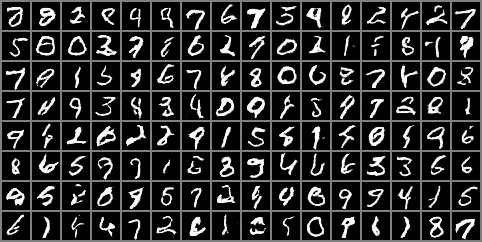

[5/5][100/468][229.6599 s]	Loss_D: -17.3034	Loss_G: 91.6664	Lip(D): 0.2257


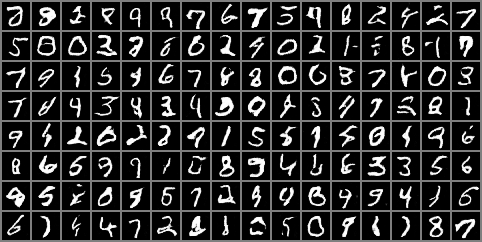

[5/5][200/468][240.8822 s]	Loss_D: -8.0016	Loss_G: -27.7224	Lip(D): 0.1755


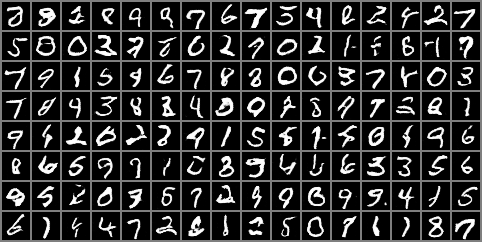

[5/5][300/468][252.3570 s]	Loss_D: -8.4898	Loss_G: 36.6975	Lip(D): 0.1896


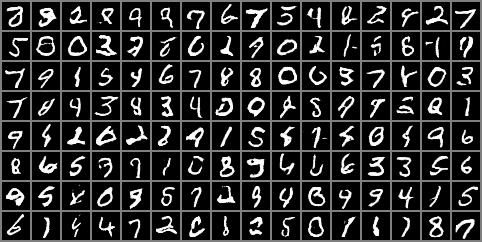

[5/5][400/468][263.6848 s]	Loss_D: -8.9891	Loss_G: 119.3845	Lip(D): 0.1805


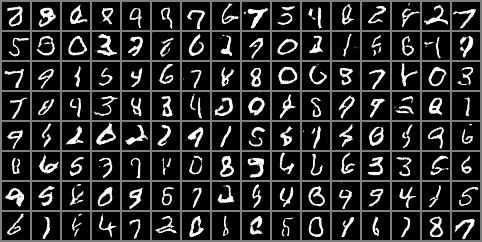

Total learning time =  272.10738825798035


<All keys matched successfully>

In [11]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network
        optimD.zero_grad() #remise à zéro des gradients

        # scores de D
        real_score = D(real).view(-1)
        fake_score = D(faked).view(-1)

        # gradient penalty
        gp = gradient_penalty(D, faked, real)

        # WGAN-GP : on minimise D(fake)-D(real)+Lamda*GP
        Dloss = fake_score.mean() - real_score.mean() + gpw * gp
        Dloss.backward()
        optimD.step()

        ############################
        # Update G network
        optimG.zero_grad()

        # nouveau bruit
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        gen = G(z)
        Gloss = -D(gen).view(-1).mean()
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [12]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())

<All keys matched successfully>

<h1 style="color:#007F5C;">Part 2 BONUS: Let's play with the Generator</h1>

<h3 style="color:#FFA82F;">Interpolation in latent space:</h3>

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

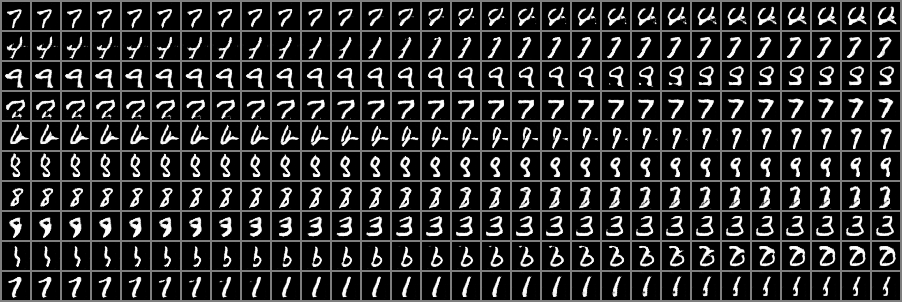

In [13]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for i in range(minib): # 10 lignes
    for k in range(nk): # 30 colonnes
        alpha = k / (nk - 1)
        z_alpha = (1 - alpha) * z0[i] + alpha * z1[i]
        with torch.no_grad():
            img = G(z_alpha.unsqueeze(0)).cpu()  # (1,1,28,28)
        genimages[i * nk + k] = img.squeeze(0) # rangée i, colonne k

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

<h3 style="color:#FFA82F;">Nearest Neighbor in the Dataset</h3>

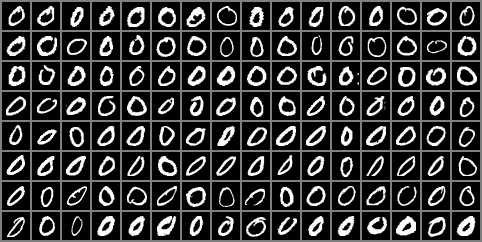

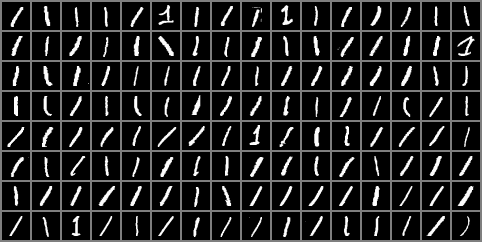

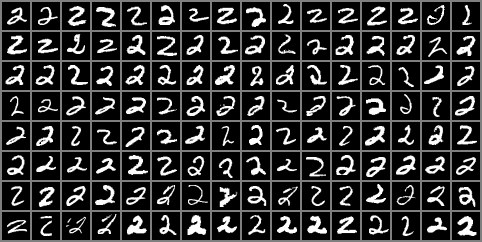

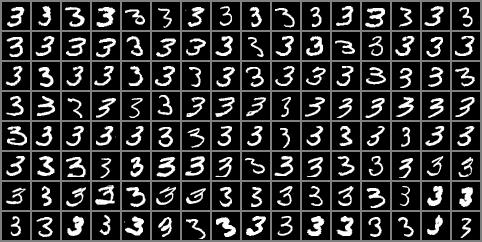

In [14]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

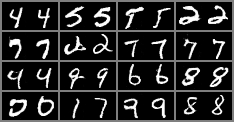

In [ ]:
nsamp = 16 
with torch.no_grad():
    z = torch.randn(nsamp, nz, 1, 1, device=device)
    fake = G(z).cpu()

flat_fake = fake.view(nsamp, -1) # (nsamp, 784)
flat_real = y.view(60000, -1).float() # base réelle aplatie

# Matrice des distances
dists = torch.cdist(flat_fake, flat_real) # (nsamp, 60000)
idx = dists.argmin(dim=1) # indice du NN pour chaque fake

# Concatène horizontalement les paires faux / voisin réel
pairs = torch.cat((fake, y[idx]), dim=3) # (nsamp,1,28,56)
imshow(torchvision.utils.make_grid(pairs, nrow=4))